Currently the code is in draft stage


. Steane Code for Error Correction
The Steane code is a quantum error-correcting code designed to protect against single-qubit errors. It encodes one logical qubit into seven physical qubits, providing protection against arbitrary single-qubit errors.
```
# Define the [[7,1,3]] Steane code for error correction
def steane_code():
    dev = qml.device("default.qubit", wires=7)

    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.Hadamard(wires=2)
        qml.CNOT(wires=[0, 3])
        qml.CNOT(wires=[1, 3])
        qml.CNOT(wires=[1, 4])
        qml.CNOT(wires=[2, 4])
        qml.CNOT(wires=[0, 5])
        qml.CNOT(wires=[2, 5])
        qml.CNOT(wires=[3, 6])
        qml.CNOT(wires=[4, 6])
        qml.CNOT(wires=[5, 6])
        return qml.state()

    return circuit
    ```


Device Initialization: dev = qml.device("default.qubit", wires=7) initializes a quantum device with 7 qubits.

Quantum Circuit Definition: @qml.qnode(dev) decorates a Python function (circuit) as a quantum node (QNode) that runs on the specified device (dev).

Quantum Operations:

Hadamard Gates: Applied to the first three qubits (qml.Hadamard(wires=0), qml.Hadamard(wires=1), qml.Hadamard(wires=2)), preparing them in a superposition state.

CNOT Gates: Implementing entanglement between qubits:

qml.CNOT(wires=[0, 3]), qml.CNOT(wires=[1, 3]), qml.CNOT(wires=[1, 4]), etc., entangle pairs of qubits according to the Steane code's layout.
Return Statement: return qml.state() returns the quantum state vector after executing all operations in the circuit.

2. Error-Corrected Grover's Algorithm (2WQC Version)
The Grover's algorithm is a quantum search algorithm that can find a solution among

N possibilities with

O(
N
​
 ) queries. Here, we implement a version of Grover's algorithm enhanced with error correction using the [[7,1,3]] Steane code.

Steane Code Integration: steane = steane_code() initializes the Steane code circuit within the Grover's algorithm circuit.

Device Initialization: dev = qml.device("default.qubit", wires=num_qubits + 1) initializes a quantum device with 5 qubits (4 qubits for Grover's algorithm + 1 ancilla qubit for error correction).

Quantum Operations:

Encode with Steane Code: steane() encodes the logical qubits into the quantum state using the previously defined Steane code.

Hadamard Gates: Applied to prepare all qubits in superposition (qml.Hadamard(wires=wire) for each wire in range(num_qubits)).

Barrier: Separates initialization from the Grover's algorithm steps.

CNOT Gates and MultiControlledX: Implement Grover's algorithm steps for quantum search and inversion about the mean.

Measurement: qml.expval(qml.PauliZ(wires=target_qubit)) measures the target qubit (qubit 0 by default) in the Z basis, providing the expectation value which correlates with the success probability of finding the solution.

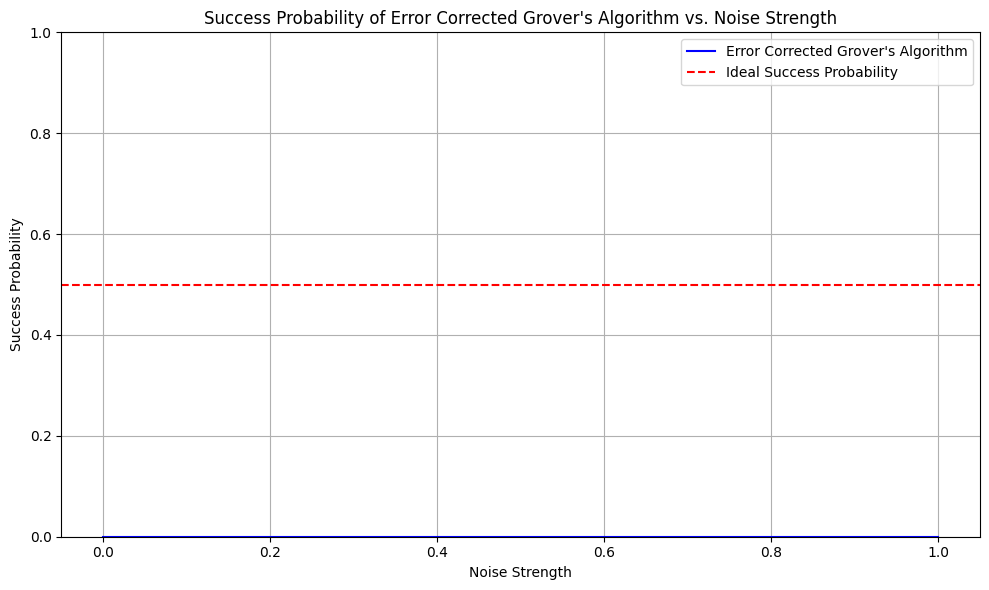

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Define the [[7,1,3]] Steane code for error correction
def steane_code():
    dev = qml.device("default.qubit", wires=7)

    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.Hadamard(wires=2)
        qml.CNOT(wires=[0, 3])
        qml.CNOT(wires=[1, 3])
        qml.CNOT(wires=[1, 4])
        qml.CNOT(wires=[2, 4])
        qml.CNOT(wires=[0, 5])
        qml.CNOT(wires=[2, 5])
        qml.CNOT(wires=[3, 6])
        qml.CNOT(wires=[4, 6])
        qml.CNOT(wires=[5, 6])
        return qml.state()

    return circuit

# Define the 2WQC version of Grover's algorithm with error correction
def error_corrected_grover_2WQC(target_qubit=0):
    steane = steane_code()

    num_qubits = 4
    dev = qml.device("default.qubit", wires=num_qubits + 1)

    @qml.qnode(dev)
    def circuit():
        # Encode logical qubits using [[7,1,3]] Steane code
        steane()

        # Apply Hadamard gates to all qubits
        for wire in range(num_qubits):
            qml.Hadamard(wires=wire)

        qml.Barrier()

        qml.CNOT(wires=[1, 3])
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[0, 2])

        qml.MultiControlledX(wires=[1, 2, 3, 4])

        qml.CNOT(wires=[0, 2])
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 3])

        # Measure the target qubit
        return qml.expval(qml.PauliZ(wires=target_qubit))

    return circuit

# Function to compute success probability under noise
def success_prob_error_corrected_grover(noise_gate, noise_strength):
    error_corrected_grover = error_corrected_grover_2WQC(target_qubit=0)

    # Create a noisy device
    dev_noisy = qml.device("default.qubit", wires=5)
    dev_noisy = qml.transforms.insert(dev_noisy, noise_gate, noise_strength)

    # QNode for the error-corrected Grover's algorithm on the noisy device
    circ_noisy = qml.QNode(error_corrected_grover, dev_noisy)

    # Evaluate the circuit and compute success probability
    success_prob = circ_noisy()

    return success_prob

# Plotting success probability vs. noise strength
noise_gate = qml.BitFlip
noise_strengths = np.linspace(0, 1, 100)
probabilities = [success_prob_error_corrected_grover(noise_gate=noise_gate, noise_strength=strength) for strength in noise_strengths]

plt.figure(figsize=(10, 6))
plt.plot(noise_strengths, probabilities, label="Error Corrected Grover's Algorithm", color='b')
plt.axhline(y=0.5, color='r', linestyle='--', label='Ideal Success Probability')

plt.xlabel('Noise Strength')
plt.ylabel('Success Probability')
plt.title("Success Probability of Error Corrected Grover's Algorithm vs. Noise Strength")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
